# import library

In [1]:
import numpy as np

import os
import torch
torch.manual_seed(0)

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18,resnet50,resnet101
from tqdm import tqdm
from typing import Dict
from torch import functional as F

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path
import pandas as pd

# Read predicted trajectory of 32 different agents to dataframe

In [2]:
ds = pd.read_csv("test_df.csv")

In [6]:
ds

,avail,id,loss,predict_x,predict_y,t,target_x,target_y
0,1.0,0.0,0.207503,0.454004,-0.019835,0.0,-0.000786,0.006009
1,1.0,0.0,0.718649,0.808398,-0.002334,1.0,-0.039318,0.002888
2,1.0,0.0,1.640201,1.246319,-0.006667,2.0,-0.034356,0.001878
3,1.0,0.0,2.583738,1.600580,0.001333,3.0,-0.006804,0.008717
4,1.0,0.0,3.021307,1.793328,-0.000903,4.0,0.055595,0.038951
...,...,...,...,...,...,...,...,...
159995,1.0,31.0,23.431311,11.226362,-0.092495,45.0,16.012882,-0.813978
159996,1.0,31.0,30.144123,10.930399,-0.102313,46.0,16.368538,-0.857805
159997,1.0,31.0,26.591259,11.614177,-0.101524,47.0,16.708190,-0.902946
159998,1.0,31.0,24.977805,12.065189,-0.060612,48.0,16.984920,-0.940413


# Plot trajectory
#### Each agent has generated 100 different trajectories on the scene  
#### We randomly pick 4 agents and plotted 100 differently generated trajectories to see diversity of the model

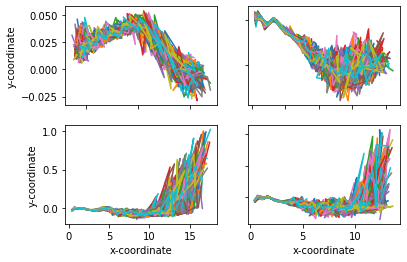

In [29]:
import matplotlib.pyplot as plt

# Define arrays to hold trajectories of each agents
arr1 = []
arr2 = []
arr3 = []
arr4 = []

# Looping 50 different time frame
# (We have generated 50 future trajectories)
for i in range(50):
    
    # Change id to see different agent's diversity
    
    agent0 = ds[(ds['id'] == 3.0) & (ds['t'] == float(i))]
    agent1 = ds[(ds['id'] == 4.0) & (ds['t'] == float(i))]
    agent2 = ds[(ds['id'] == 28.0) & (ds['t'] == float(i))]
    agent3 = ds[(ds['id'] == 2.0) & (ds['t'] == float(i))]

    # Save agent's predicted trajectories
    
    li = agent0[['predict_x', 'predict_y']].values
    li1 = agent1[['predict_x', 'predict_y']].values
    li2 = agent2[['predict_x', 'predict_y']].values
    li3 = agent3[['predict_x', 'predict_y']].values
    
    # Make sure they are equal length
    assert(len(li) == len(li1) == len(li2) == len(li3))
    
    # Create dictionaries for each of generated trajectories for agent1

    for j in range(len(li)):
        if i == 0:
            dic = {}
            dic['predict_x'] = [li[j][0]]
            dic['predict_y'] = [li[j][1]]  
            arr1.append(dic)
        else:
            arr1[j]['predict_x'].append(li[j][0])
            arr1[j]['predict_y'].append(li[j][1])

    # Create dictionaries for each of generated trajectories for agent2

    for q in range(len(li1)):
        if i == 0:
            dic = {}
            dic['predict_x'] = [li1[q][0]]
            dic['predict_y'] = [li1[q][1]]     
            arr2.append(dic)
        else:
            arr2[q]['predict_x'].append(li1[q][0])
            arr2[q]['predict_y'].append(li1[q][1])

    # Create dictionaries for each of generated trajectories for agent3

    for z in range(len(li2)):
        if i == 0:
            dic = {}
            dic['predict_x'] = [li2[z][0]]
            dic['predict_y'] = [li2[z][1]]            
            arr3.append(dic)
        else:
            arr3[z]['predict_x'].append(li2[z][0])
            arr3[z]['predict_y'].append(li2[z][1])
  
    # Create dictionaries for each of generated trajectories for agent4

    for k in range(len(li3)):
        if i == 0:
            dic = {}
            dic['predict_x'] = [li3[k][0]]
            dic['predict_y'] = [li3[k][1]]            
            arr4.append(dic)
        else:
            arr4[k]['predict_x'].append(li3[k][0])
            arr4[k]['predict_y'].append(li3[k][1])

# Make sure each array has 100 different trajectories

assert(len(arr1) == len(arr2) == len(arr3) == len(arr4))      

# Plot 2 x 2 graphs

fig, axs = plt.subplots(2,2)  

# 4 agents and 100 different trajectories

for i in range(4):        
    for j in range(100):
        if i == 0:
            axs[0,0].plot(arr1[j]['predict_x'], arr1[j]['predict_y'])
        elif i == 1:
            axs[0,1].plot(arr2[j]['predict_x'], arr2[j]['predict_y'])
        elif i == 2:
            axs[1,0].plot(arr3[j]['predict_x'], arr3[j]['predict_y'])
        else:
            axs[1,1].plot(arr4[j]['predict_x'], arr4[j]['predict_y'])

# Set x-axis, y-axis title

for ax in axs.flat:
    ax.set(xlabel='x-coordinate', ylabel='y-coordinate')

# Hide x labels and tick labels for top plots and y ticks for right plots.

for ax in axs.flat:
    ax.label_outer()

plt.show()